In [1]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive/surely_not_sarcasm_data/'

Mounted at /content/drive


In [ ]:
!pip install contractions
!cp -r '$root/utils' .

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import keras
import pickle

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, LSTM, BatchNormalization, Dropout, Concatenate, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2

from utils.preprocessing import WordEmbeddings
from utils.evaluation import plot_history, evaluate, show_errors

sns.set_style('whitegrid');
sns.set_context('notebook', font_scale=1.2);

# prepare data

In [4]:
raw_data = pickle.load(open(root+'raw_data_0604', 'rb'))

In [5]:
vocab_size = 10000
input_dim = vocab_size + 2 # one for padding, one for oov token

In [6]:
data = pickle.load(open(root+'preprocessed_data_0604', 'rb'))

In [7]:
maxlen = int(data['X_train'].str.split().str.len().quantile(0.9))
maxlen_par = int(data['X_train_par'].str.split().str.len().quantile(0.9))

In [8]:
tokenizer_layer = TextVectorization(max_tokens=input_dim, output_sequence_length=maxlen, standardize=None)
tokenizer_layer.adapt(data['X_train'])

In [20]:
tokenizer_par_layer = TextVectorization(max_tokens=input_dim, output_sequence_length=maxlen_par, standardize=None)
tokenizer_par_layer.adapt(data['X_train_par'])

# no context

In [9]:
vec_len = 100
wordemb = WordEmbeddings()
emb_matrix_comment = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer_layer.get_vocabulary(), root=root)

coverage: 0.9813


## CNN + biLSTM
*Deep CNN-LSTM with Word Embeddings for News Headline Sarcasm Detection*  
09.04.2022

In [10]:
model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    tokenizer_layer,
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
              mask_zero=True, weights=[emb_matrix_comment], trainable=True,
              embeddings_regularizer=L1L2(l1=5e-6, l2=5e-6)),
    Conv1D(32, 3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling1D(3),
    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same'),
    BatchNormalization(),
    Bidirectional(LSTM(20, dropout=0.3)),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(data['X_train'], data['y_train'], batch_size=128, epochs=50, callbacks=[es],
                validation_data=(data['X_val'], data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 139s 21ms/step - loss: 1.2074 - accuracy: 0.7072 - val_loss: 0.6956 - val_accuracy: 0.7257
Epoch 2/50
6002/6002 [==============================] - 120s 20ms/step - loss: 0.6481 - accuracy: 0.7289 - val_loss: 0.6186 - val_accuracy: 0.7322
Epoch 3/50
6002/6002 [==============================] - 124s 21ms/step - loss: 0.6046 - accuracy: 0.7354 - val_loss: 0.6111 - val_accuracy: 0.7278
Epoch 4/50
6002/6002 [==============================] - 118s 20ms/step - loss: 0.5885 - accuracy: 0.7397 - val_loss: 0.5889 - val_accuracy: 0.7359
Epoch 5/50
6002/6002 [==============================] - 121s 20ms/step - loss: 0.5803 - accuracy: 0.7420 - val_loss: 0.5816 - val_accuracy: 0.7386
Epoch 6/50
6002/6002 [==============================] - 118s 20ms/step - loss: 0.5755 - accuracy: 0.7451 - val_loss: 0.5816 - val_accuracy: 0.7402
Epoch 7/50
6002/6002 [==============================] - 119s 20ms/step - loss: 0.5726 - accuracy: 0.7472 - val_loss: 0

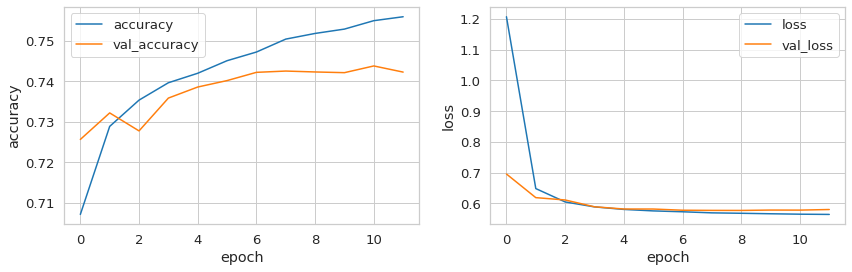

In [11]:
plot_history(fit)

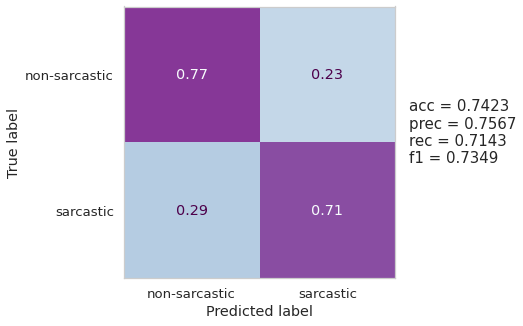

In [12]:
evaluate(model, data['X_val'], data['y_val'])

In [13]:
show_errors(model, raw_data['X_val'].values, data['X_val'], data['y_val'])

False negatives:
---------------------------
My grandpa used to use the term 'nigger hair' for tobacco, is that racist?
Doing that has been confirmed to grant you 0% chance of legendaries
Why not just make LA pay that as well!
It's like when the hot pocket is hot everywhere but the middle so you add 10 seconds and the filling leaks.
Remember last year when we beat you?

False positives:
---------------------------
Clicking on that article will land you on best korean watch list
Yeah, they were never supporting Bernie because of progressive causes; they're supporting hi because they're a bunch of angsty nihilists that don't understand how good they have things.
please fix it, it's giving me cancer
Jim Harbaugh
Yes, it allows us to have a law for the recognition of eSports independent of the EU's governing body.


In [14]:
model.save(root+'models/cnn_bilstm')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/cnn_bilstm/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/cnn_bilstm/assets


## CNN + LSTM + DNN
*Fracking Sarcasm using Neural Network*  
09.04.2022

In [15]:
model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    tokenizer_layer,
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
              mask_zero=True, weights=[emb_matrix_comment], trainable=True,
              embeddings_regularizer=L1L2(l1=5e-6, l2=5e-6)),
    Conv1D(64, 3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv1D(128, 3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    LSTM(50, dropout=0.25, return_sequences=True),
    LSTM(50, dropout=0.25),
    Dense(50, activation='relu', kernel_initializer='he_normal'),
    Dense(1, activation='sigmoid')
])

es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(data['X_train'], data['y_train'], batch_size=128, epochs=50, callbacks=[es],
                validation_data=(data['X_val'], data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 173s 28ms/step - loss: 1.1267 - accuracy: 0.7079 - val_loss: 0.6775 - val_accuracy: 0.7264
Epoch 2/50
6002/6002 [==============================] - 175s 29ms/step - loss: 0.6344 - accuracy: 0.7301 - val_loss: 0.6119 - val_accuracy: 0.7307
Epoch 3/50
6002/6002 [==============================] - 168s 28ms/step - loss: 0.5967 - accuracy: 0.7368 - val_loss: 0.5863 - val_accuracy: 0.7393
Epoch 4/50
6002/6002 [==============================] - 166s 28ms/step - loss: 0.5824 - accuracy: 0.7413 - val_loss: 0.5822 - val_accuracy: 0.7400
Epoch 5/50
6002/6002 [==============================] - 163s 27ms/step - loss: 0.5756 - accuracy: 0.7440 - val_loss: 0.5785 - val_accuracy: 0.7410
Epoch 6/50
6002/6002 [==============================] - 164s 27ms/step - loss: 0.5715 - accuracy: 0.7471 - val_loss: 0.5758 - val_accuracy: 0.7434
Epoch 7/50
6002/6002 [==============================] - 167s 28ms/step - loss: 0.5683 - accuracy: 0.7502 - val_loss: 0

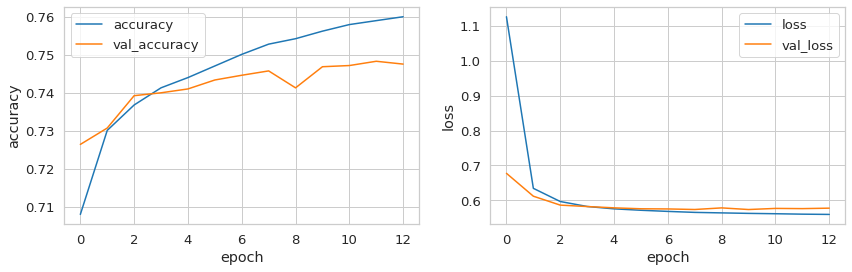

In [16]:
plot_history(fit)

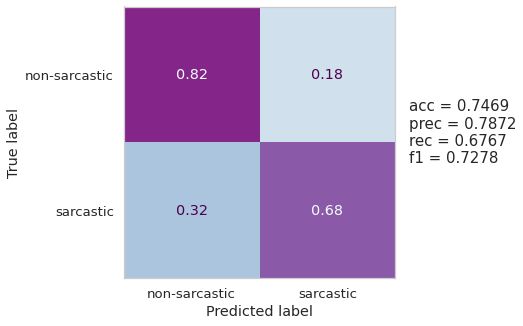

In [17]:
evaluate(model, data['X_val'], data['y_val'])

In [18]:
show_errors(model, raw_data['X_val'].values, data['X_val'], data['y_val'])

False negatives:
---------------------------
It is if you're Volvo.
I can't even run Pong '66
Dyslexic and grammar impaired people?
Even Lounge wants to sway the odds.
That's what the express lanes are for.

False positives:
---------------------------
OP - Lesbians are Gay
If you had a sports car you coulda got there faster.
Well then the comment is even more pointless then I could have ever imagined
Don't worry, someone will eventually leak the answer from the NSA archives.
Yeah it's not too bad when you do it like that.


In [19]:
model.save(root+'models/cnn_lstm_dnn')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/cnn_lstm_dnn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/cnn_lstm_dnn/assets


# context
09.04.2022

## 2 $\times$ CNN-LSTM-DNN 

In [21]:
vec_len = 100

wordemb = WordEmbeddings()
emb_matrix_comment = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer_layer.get_vocabulary(), root=root)
emb_matrix_parent = wordemb.get_glove_embeddings(input_dim, vec_len, tokenizer_par_layer.get_vocabulary(), root=root)

coverage: 0.9813
coverage: 0.9888


In [27]:
train_data = {'comment': data['X_train'], 'parent': data['X_train_par']}
val_data = {'comment': data['X_val'], 'parent': data['X_val_par']}

In [28]:
def build_cnn_rnn(tok_layer, embedding_matrix, maxlen, reg=1e-6):
    x = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                  mask_zero=True, weights=[embedding_matrix], trainable=True,
                  embeddings_regularizer=L1L2(l1=reg, l2=reg))(tok_layer)
    x = Conv1D(64, 3, activation='relu', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Conv1D(128, 3, activation='relu', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LSTM(50, dropout=0.25, return_sequences=True)(x)
    x = LSTM(50, dropout=0.25)(x)

    return x

In [29]:
comment_input =  keras.Input(shape=(1,), name='comment', dtype=tf.string)
parent_input = keras.Input(shape=(1,), name='parent', dtype=tf.string)

tokenize_comment = tokenizer_layer(comment_input)
tokenize_parent = tokenizer_par_layer(parent_input)

comment_rnn = build_cnn_rnn(tokenize_comment, emb_matrix_comment, maxlen, reg=5e-6)
parent_rnn = build_cnn_rnn(tokenize_parent, emb_matrix_parent, maxlen_par, reg=5e-6)

x = Concatenate()([comment_rnn, parent_rnn])
x = Dense(100, activation='elu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, restore_best_weights=True)

model = keras.Model(inputs=[comment_input, parent_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(train_data, data['y_train'], epochs=50, batch_size=128, callbacks=[es],
                validation_data=(val_data, data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 436s 71ms/step - loss: 1.5441 - accuracy: 0.7022 - val_loss: 0.6957 - val_accuracy: 0.7263
Epoch 2/50
6002/6002 [==============================] - 443s 74ms/step - loss: 0.6463 - accuracy: 0.7289 - val_loss: 0.6147 - val_accuracy: 0.7331
Epoch 3/50
6002/6002 [==============================] - 442s 74ms/step - loss: 0.6003 - accuracy: 0.7365 - val_loss: 0.5889 - val_accuracy: 0.7382
Epoch 4/50
6002/6002 [==============================] - 444s 74ms/step - loss: 0.5845 - accuracy: 0.7409 - val_loss: 0.5789 - val_accuracy: 0.7417
Epoch 5/50
6002/6002 [==============================] - 444s 74ms/step - loss: 0.5786 - accuracy: 0.7445 - val_loss: 0.5799 - val_accuracy: 0.7418
Epoch 6/50
6002/6002 [==============================] - 444s 74ms/step - loss: 0.5734 - accuracy: 0.7468 - val_loss: 0.5732 - val_accuracy: 0.7434
Epoch 7/50
6002/6002 [==============================] - 443s 74ms/step - loss: 0.5712 - accuracy: 0.7491 - val_loss: 0

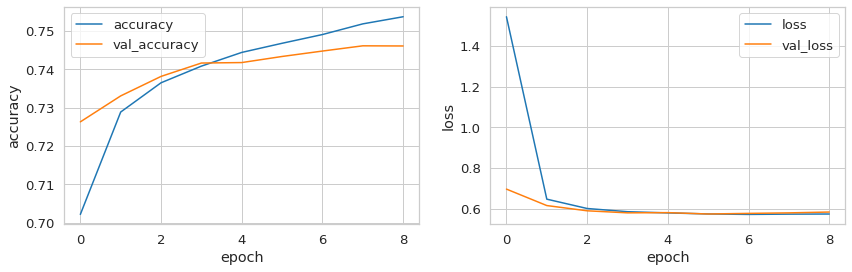

In [30]:
plot_history(fit)

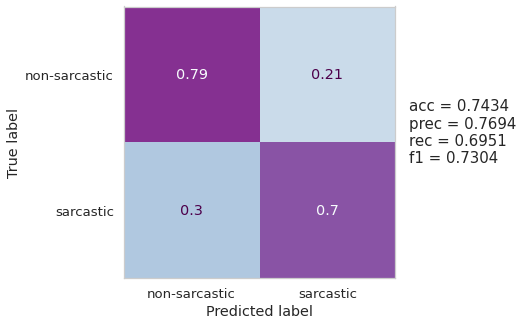

In [31]:
evaluate(model, (data['X_val'], data['X_val_par']), data['y_val'])

In [32]:
show_errors(model, raw_data['X_val'].values, (data['X_val'], data['X_val_par']),
            data['y_val'], X_parents=raw_data['X_val_par'].values)

False negatives:
---------------------------
parent: Yeah, it was a huge surprise that none of the rednecks understood satire.
comment: As a citizen of western Kentucky, I'm stunned

parent: I got ward for 190k about which is nice. Beast so far.
comment: Massive overpay, he usually goes for like 8K along with Whitner and Iloka

parent: Stefan Savic dribble from halfway line and goal for Slaven Belupo vs Cibalia (4-0)
comment: He transferred?

parent: So now all of Roy's hits kill you at 70?
comment: He does that anyway.

parent: Maybe they are busy porting to source 2 or fixing big bugs.....
comment: Most likely scenario: building up a list of stickers or music kits.


False positives:
---------------------------
parent: The Great Gatsby is a novel. Also, the most famous film adaptation stars Robert Redford.
comment: Yea but there is also a movie, OP never specified.

parent: The irony is that he railed against government employees that don't do their jobs but still collect their paych

In [33]:
model.save(root+'models/context_cnn_lstm_dnn')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/context_cnn_lstm_dnn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/context_cnn_lstm_dnn/assets


## comment: RNN, parent: CNN

In [34]:
train_data = {'comment': data['X_train'], 'parent': data['X_train_par']}
val_data = {'comment': data['X_val'], 'parent': data['X_val_par']}

In [35]:
def build_cnn(tok_layer, embedding_matrix, maxlen, reg=1e-6):
    x = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                  mask_zero=True, weights=[embedding_matrix], trainable=True,
                  embeddings_regularizer=L1L2(l1=reg, l2=reg))(tok_layer)

    x = Conv1D(64, 2, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv1D(64, 2, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Dropout(0.3)(x)

    x = Conv1D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv1D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)

    x = GlobalMaxPooling1D()(x)

    return x

In [36]:
def build_rnn(tok_layer, embedding_matrix, maxlen, reg=1e-6):
    x = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                  mask_zero=True, weights=[embedding_matrix], trainable=True,
                  embeddings_regularizer=L1L2(l1=reg, l2=reg))(tok_layer)
    x = GRU(100, dropout=0.4)(x)

    return x

In [37]:
comment_input =  keras.Input(shape=(1,), name='comment', dtype=tf.string)
parent_input = keras.Input(shape=(1,), name='parent', dtype=tf.string)

tokenize_comment = tokenizer_layer(comment_input)
tokenize_parent = tokenizer_par_layer(parent_input)

comment_rnn = build_rnn(tokenize_comment, emb_matrix_comment, maxlen, reg=3e-6)
parent_cnn = build_cnn(tokenize_parent, emb_matrix_parent, maxlen_par, reg=5e-6)

x = Concatenate()([comment_rnn, parent_cnn])
x = Dense(100, activation='elu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

es = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=3, restore_best_weights=True)

model = keras.Model(inputs=[comment_input, parent_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
fit = model.fit(train_data, data['y_train'], epochs=50, batch_size=128, callbacks=[es],
                validation_data=(val_data, data['y_val']))

Epoch 1/50
6002/6002 [==============================] - 284s 46ms/step - loss: 1.8770 - accuracy: 0.7012 - val_loss: 0.6925 - val_accuracy: 0.7243
Epoch 2/50
6002/6002 [==============================] - 281s 47ms/step - loss: 0.6396 - accuracy: 0.7293 - val_loss: 0.6048 - val_accuracy: 0.7369
Epoch 3/50
6002/6002 [==============================] - 282s 47ms/step - loss: 0.5983 - accuracy: 0.7378 - val_loss: 0.5836 - val_accuracy: 0.7415
Epoch 4/50
6002/6002 [==============================] - 281s 47ms/step - loss: 0.5850 - accuracy: 0.7435 - val_loss: 0.5762 - val_accuracy: 0.7459
Epoch 5/50
6002/6002 [==============================] - 281s 47ms/step - loss: 0.5791 - accuracy: 0.7468 - val_loss: 0.5751 - val_accuracy: 0.7467
Epoch 6/50
6002/6002 [==============================] - 277s 46ms/step - loss: 0.5753 - accuracy: 0.7503 - val_loss: 0.5704 - val_accuracy: 0.7505
Epoch 7/50
6002/6002 [==============================] - 279s 47ms/step - loss: 0.5729 - accuracy: 0.7533 - val_loss: 0

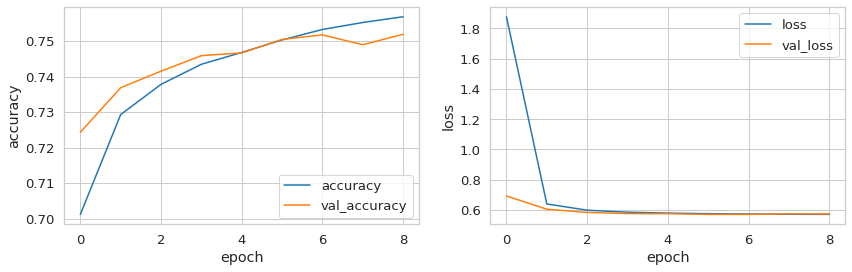

In [38]:
plot_history(fit)

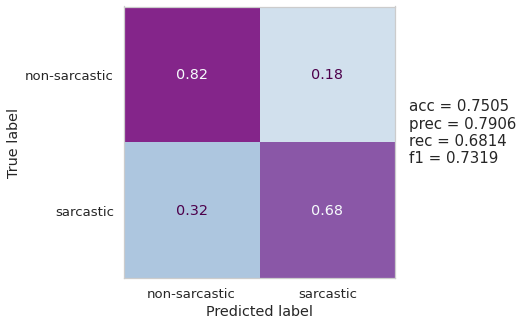

In [39]:
evaluate(model, (data['X_val'], data['X_val_par']), data['y_val'])

In [40]:
show_errors(model, raw_data['X_val'].values, (data['X_val'], data['X_val_par']),
            data['y_val'], X_parents=raw_data['X_val_par'].values)

False negatives:
---------------------------
parent: It's almost as if reddit has more Bernie supporters than Hillary supporters...
comment: The fair thing would be to allow Hillary's SuperPacs to pay money to put her articles at the top of reddit.

parent: 1. Jimmy Butler, foundational piece and all-star 2. Hassan Whiteside, the man who came from nothing 3. The Golden State Warriors, the best team in basketball 4. Rookie injuries, to an unprecedented degree 5. The current Atlanta Hawks win streak, going on 20 games 6. Khris Middleton, quietly the best player on a playoff team 7. Nikola Vucevic, who looked good for years but suddenly looks great 8. DeMarcus Cousins, the mature, composed professional athlete 9. Larry Sanders and the Art of Self-immolation 10. The precipitous but largely unacknowledged decline of Dwight Howard
comment: Kentucky would like a word about 3.

parent: Go by trivial, because I like the word. Basically a mildly pretentious way of saying unimportant or useless.


In [41]:
model.save(root+'models/context_rnn_cnn')

INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/context_rnn_cnn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/surely_not_sarcasm_data/models/context_rnn_cnn/assets
